<a href="https://colab.research.google.com/github/adantra/ML_Stocks/blob/master/Darcy2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nangs

In [2]:
# autoreload nangs
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#imports

import numpy as np 
import matplotlib.pyplot as plt 
import torch
import pandas as pd
import nangs
from nangs import *

device = "cuda" if torch.cuda.is_available() else "cpu"

nangs.__version__, torch.__version__

('0.1.2', '1.9.0+cu102')

In [4]:
device


'cpu'

In [5]:
alpha=0.0
class Difussion2d(PDE):
    def computePDELoss(self, inputs, outputs):
        p = outputs[:, 0]
        grads = self.computeGrads(p, inputs)
        dpdx, dpdy = grads[:, 0], grads[:, 1]
        x=inputs[:,1]
        # second order derivatives        
        dp2dx2 = self.computeGrads(dpdx, inputs)[:, 0] 
        dp2dy2 = self.computeGrads(dpdy, inputs)[:, 1]
        return {'loss':alpha - (dp2dx2 + dp2dy2)}

In [6]:
class NeumannX(Neumann):
    def computeBocoLoss(self, inputs, outputs):
        p = outputs[:, 0]
        grads = self.computeGrads(p, inputs)
        dpdx = grads[:, 0]
        return {'gradX': dpdx}

In [7]:
class NeumannY(Neumann):
    def computeBocoLoss(self, inputs, outputs):
        p = outputs[:, 0]
        grads = self.computeGrads(p, inputs)
        dpdy = grads[:, 1]
        return {'gradX': dpdy}

In [8]:
pde = Difussion2d(inputs=('x', 'y'), outputs='p')

In [9]:
# mesh 

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
t = np.linspace(0,1,20)

mesh = Mesh({'x': x, 'y': y}, device=device)
pde.set_mesh(mesh)

In [10]:
from nangs import Dirichlet

In [11]:
t0 = np.array([0])

In [12]:
_x, _y = np.meshgrid(x, y)
p0 = np.sin(2*np.pi*_x)*np.sin(2*np.pi*_y)

In [13]:
p0=np.zeros((100,100))
p0[:]=0
#p0[47:53,47:53]=1

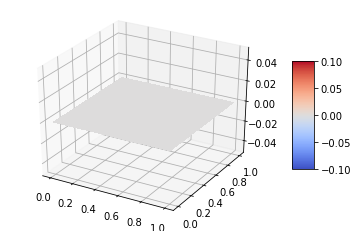

In [14]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(_x, _y, p0.reshape((_y.shape[0],_x.shape[1])), cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [15]:
#initial_condition = Dirichlet({'x': x, 'y': y}, {'p': p0.reshape(-1)}, device=device, name="initial")

In [16]:
#pde.add_boco(initial_condition)
p0=np.ones(len(y))
p1=np.zeros(len(y))

In [17]:
#left = NeumannX({'x': np.array([0]), 'y': y, 't':t}, name='left', device=device)
left = Dirichlet({'x': x[0], 'y': y}, {'p': p0.reshape(-1)}, device=device, name="left")

In [18]:
pde.add_boco(left)

In [19]:
#right = NeumannX({'x': np.array([1]), 'y': y, 't':t}, name='right', device=device)
right = Dirichlet({'x': x[-1], 'y': y}, {'p': p1.reshape(-1)}, device=device, name="right")

In [20]:
pde.add_boco(right)

In [21]:

top = NeumannY({'x': x, 'y': y[-1]}, name='top', device=device)

In [22]:
pde.add_boco(top)

In [23]:
bottom = NeumannY({'x': x, 'y': y[-1]}, name='bottom', device=device)

In [24]:
pde.add_boco(bottom)

In [111]:
from nangs import MLP

BATCH_SIZE = 512
LR = 1e-2
EPOCHS = 15
NUM_LAYERS = 2
NUM_HIDDEN = 3*50

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, total_steps=EPOCHS)

In [112]:
pde.compile(mlp, optimizer, scheduler)

In [113]:
%time hist = pde.solve(EPOCHS, BATCH_SIZE)

CPU times: user 8.7 s, sys: 434 ms, total: 9.13 s
Wall time: 9.1 s


In [114]:
t = 0.01
x = np.linspace(0,1,100)
y = np.linspace(0,1,100)

_x, _y = np.meshgrid(x, y)

In [115]:
eval_mesh = Mesh({'x': x, 'y': y}, device=device)
p = pde.eval(eval_mesh)
p = p.cpu().numpy()

In [116]:
p.shape

(10000, 1)

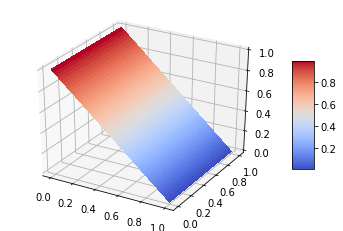

In [117]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(_x, _y, p.reshape((_y.shape[0],_x.shape[1])), cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [118]:
p1=p.reshape((_y.shape[0],_x.shape[1]))

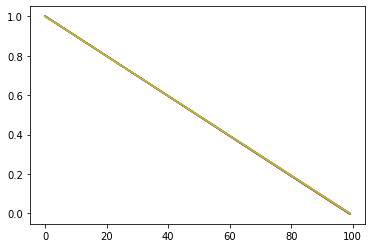

In [119]:
plt.plot(p1[0])
plt.plot(p1[1])
plt.plot(p1[2])
plt.plot(p1[3])
plt.plot(p1[4])
plt.plot(p1[-1])
plt.plot(p1[-2])
plt.plot(p1[-3])
plt.plot(p1[-4])

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
ls '/content/gdrive/MyDrive'

'070201 EQM-KY7-002 s.doc.gdoc'
 08272013-02272014.pdf
 Agenda08_30_final.gdoc
'Alan Aug 2008 Flyer.gdoc'
 Analysis
'Awesome Note'/
 azcopy
'Boarding Pass - Check-in _ Spirit Airlines.pdf'
 carta.gdoc
 cartas.gdoc
'Clase 2'/
 Classroom/
 cluster.pdf
'Colab Notebooks'/
'Comp3 KY6 ProjectProg_Aug07.gdoc'
'Comp3 KY7 ProjectProg_Aug07.gdoc'
 Comp3ProjectProg_Feb07.doc.gdoc
 Comp3ProjectProg_June07.gdoc
 Conferencia1.xlsx
'Corodoba Court lawn service 090614.xlsx'
'Corodoba Court lawn service 090614.xlsx.gsheet'
'Crear subrutina para creacion de grid.gdoc'
'Curso_OG_en_Day 1.pptx'
 CURSO_PERU/
'Datos de entrada'
 DESARROLLO.gdoc
'displacement bc'
 DSC09906.JPG
 DSC09906.png
 EmotivGamePatch1_zip.gdoc
 EQM-KY07-02.doc.gdoc
'Estimado Stefan corregido.doc.gdoc'
 File_001.png
 Geomechanics
'Geomechanics with Python. Part 1.mp4'
 geo_mult.gdoc
'Google Buzz'/
'Hoy estoy trabajando en STOMP. Hace f....gdoc'
'http:  www.sleekwire.com index.php?pa....gdoc'
"Imported from Google Notebook - Asperger's.